In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy.stats.distributions import halfcauchy
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from factor_analyzer import FactorAnalyzer
import joblib
import os
import matplotlib.font_manager as font_manager
import onnx
import netron
import utils


详细信息: Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo; Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a); Inattentive or easily distracted No presta atención o se distrae fácilmente


# Main 

## preparing the data

In [2]:
qns = pd.read_csv(r'data\data_cleaned.csv') # the cbcl data
X = qns.iloc[:,2:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.4)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

## Train and save the model

Early stopping at epoch 105


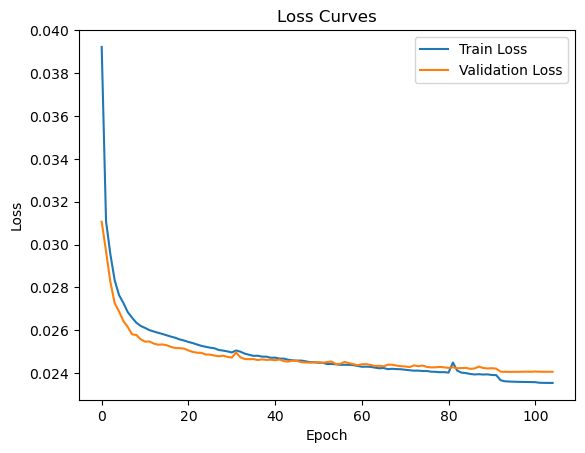

Explained variance ratio of latent factor 1: 0.07063912
Explained variance ratio of latent factor 2: 0.04003555
Explained variance ratio of latent factor 3: 0.04991080
Explained variance ratio of latent factor 4: 0.09228681
Explained variance ratio of latent factor 5: 0.07821929
Total explained variance ratio (by all factors): 0.40821445


In [3]:
from utils import Autoencoder
autoencoder = Autoencoder(X_train, X_val, encoding_dim=5)
autoencoder.train()
latent_factors, reconstruction_errors_test, explained_variance_ratios, explained_variance_ratio_test = autoencoder.evaluate_on_data(X_scaled)

In [ ]:
autoencoder.export_to_onnx(X_train)

In [ ]:
# 确保 latent_df 和 X_scaled 是 NumPy 数组或 Pandas DataFrame
latent_factors = latent_factors  # 转换为 NumPy 数组
X_scaled = np.array(X_scaled)  # 假设原始标准化数据也为 NumPy 数组

# 计算加载矩阵
loadings = []
for i in range(X_scaled.shape[1]):  # 遍历每个原始特征
    reg = LinearRegression().fit(latent_factors, X_scaled[:, i])  # 回归
    loadings.append(reg.coef_)  # 存储回归系数

loading_matrix = np.array(loadings).T  # 转置为 (潜在因子数, 原始特征数)

# 打印加载矩阵的形状
print("Loading matrix shape:", loading_matrix.shape)


Loading matrix shape: (5, 114)


## Explore the possible dimensions of the hidden layer

dim: 4
Early stopping at epoch 121


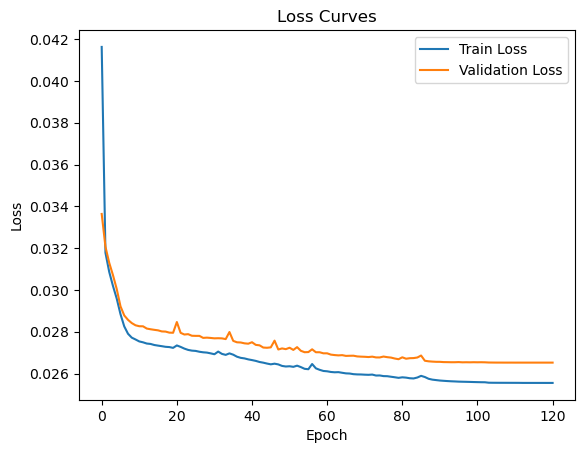

Explained variance ratio of latent factor 1: 0.17539750
Explained variance ratio of latent factor 2: 0.32388270
Explained variance ratio of latent factor 3: 0.19786413
Explained variance ratio of latent factor 4: 0.25852615
Total explained variance ratio (by all factors): 0.35902904
dim: 5


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_7904\1721370153.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 93


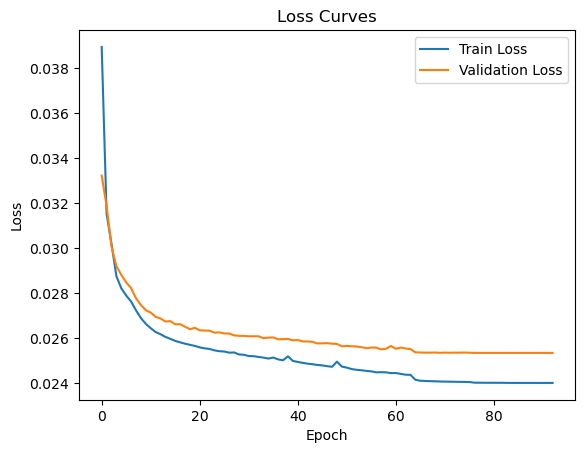

Explained variance ratio of latent factor 1: 0.04860438
Explained variance ratio of latent factor 2: 0.04158183
Explained variance ratio of latent factor 3: 0.18120742
Explained variance ratio of latent factor 4: 0.09359328
Explained variance ratio of latent factor 5: 0.08933282
Total explained variance ratio (by all factors): 0.39546963
  dim  Factor_1  Factor_2  Factor_3  Factor_4  Factor_5 Factor_6 Factor_7  \
0   4  0.175398  0.323883  0.197864  0.258526       NaN     None     None   
1   5  0.048604  0.041582  0.181207  0.093593  0.089333     None     None   

  Factor_8 Factor_9 Factor_10  Total variance ratio  
0     None     None      None              0.359029  
1     None     None      None              0.395470  


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_7904\1721370153.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


In [7]:
from utils import Autoencoder
import pandas as pd
import torch
import numpy as np

# Initialize the DataFrame to store the results
dim_df = pd.DataFrame(columns=["dim"] + [f"Factor_{i+1}" for i in range(10)] + ["Total variance ratio"])

for latent_dim in range(4, 6):
    print("dim:", latent_dim)
    
    # Initialize and train the autoencoder
    autoencoder = Autoencoder(X_train, X_val, encoding_dim=latent_dim)
    autoencoder.train()
    
    # Evaluate the autoencoder on the scaled data
    latent_factors, reconstruction_errors, explained_variance_ratios, explained_variance_ratio_total = autoencoder.evaluate_on_data(X_scaled)
    
    # Create a temporary DataFrame to store the results for the current latent dimension
    temp_df = pd.DataFrame({
        "dim": [latent_dim],  # Current dimension
        **{f"Factor_{i+1}": ratio for i, ratio in enumerate(explained_variance_ratios)},
        "Total variance ratio": [explained_variance_ratio_total]
    })
    
    # Fill missing factor columns with NaN to maintain consistent column names
    for col in dim_df.columns:
        if col not in temp_df.columns:
            temp_df[col] = None  # Fill with NaN
    
    # Sort columns to match the order in dim_df
    temp_df = temp_df[dim_df.columns]
    
    # Concatenate the temporary DataFrame with the main DataFrame
    dim_df = pd.concat([dim_df, temp_df], ignore_index=True)

print(dim_df)

## NMF

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF

# 假设 data_cleaned 是一个非负矩阵 (pandas DataFrame 或 numpy 数组)
data_cleaned = qns.iloc[:,2:]

# 定义 NMF 分解参数
rank = 5  # 提取的成分数量

# 执行 NMF 分解
nmf_model = NMF(n_components=rank, init='random', solver='mu', max_iter=1000, random_state=42)
W = nmf_model.fit_transform(data_cleaned)  # 基矩阵 W
H = nmf_model.components_  # 系数矩阵 H

# 查看重构误差
reconstruction_error = nmf_model.reconstruction_err_
print(f"Reconstruction error: {reconstruction_error}")

# 执行矩阵乘法以重构原始矩阵
X_reconstructed = np.dot(W, H)

# 计算 Frobenius 范数
X_norm = np.linalg.norm(data_cleaned, ord='fro')
reconstruction_error_frobenius = np.linalg.norm(data_cleaned - X_reconstructed, ord='fro')

# 计算相对误差
relative_error = reconstruction_error_frobenius / X_norm
print(f"Relative Error: {relative_error}")

# 计算解释方差的比例
# 确保 data_cleaned 是 Numpy 数组
data_cleaned_np = data_cleaned.to_numpy()  # 如果 data_cleaned 是 DataFrame，转换为 Numpy 数组

# 计算原始数据矩阵的总方差
total_variance = np.sum((data_cleaned_np - np.mean(data_cleaned_np))**2)

# 计算重构矩阵的方差
reconstructed_variance = np.sum((X_reconstructed - np.mean(X_reconstructed))**2)

# 确保 variance_explained 是标量
variance_explained = reconstructed_variance / total_variance
print(f"Variance explained by the NMF model: {variance_explained * 100:.2f}%")

# 将 ID 列添加到 W
W_with_id = pd.concat([pd.Series(qns.iloc[:,1], name='ID'), pd.DataFrame(W)], axis=1)

# 转置 H
H_transposed = H.T

Reconstruction error: 360.5433105714273
Relative Error: 0.7230225753500522
Variance explained by the NMF model: 37.77%


## Interpretability

### results from autoencoder

In [ ]:
# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = latent_factors.values if isinstance(latent_factors, pd.DataFrame) else latent_factors
original_features = X if isinstance(X, np.ndarray) else X.values

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]

loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(loadings, columns=[f'Latent_{j+1}' for j in range(n_latent_factors)])
loadings_df.index = [f'Feature_{i+1}' for i in range(n_original_features)]

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）the loading matrix of the autoencoder
print(loadings_df)


             Latent_1  Latent_2  Latent_3  Latent_4  Latent_5  Latent_6
Feature_1   -0.001291  0.174298 -0.303561 -0.053776  0.261539  0.080035
Feature_2   -0.543066  0.457667 -0.063471  0.259146  0.123756  0.522071
Feature_3   -0.001308  0.242078 -0.531825 -0.075450  0.481615  0.048605
Feature_4   -0.021032  0.155467 -0.133745 -0.126422  0.064554  0.189535
Feature_5   -0.002116  0.031541 -0.024610 -0.023332  0.012394  0.018659
...               ...       ...       ...       ...       ...       ...
Feature_110 -0.027907  0.098043 -0.066863 -0.024803  0.046104 -0.002161
Feature_111 -0.178378  0.253067  0.061340  0.068117  0.223048  0.309915
Feature_112  0.001624  0.008510 -0.005498 -0.007304  0.005283  0.007995
Feature_113  0.035763  0.135797 -0.139068 -0.205405  0.048244  0.197138
Feature_114  0.132240 -0.047625  0.269379 -0.004249  0.451223  0.464439

[114 rows x 6 columns]


In [28]:
loadings_df.index = qns.iloc[:,2:].columns
df = pd.DataFrame()
for i in range(latent_dim):
    df0 = loadings_df['Latent_{0}'.format(i+1)].reindex(
        loadings_df['Latent_{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='Latent_{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name'})
    df = pd.concat([df, df0], axis=1)
df_even_columns = df.iloc[:, ::2]  # # Select all rows and every second column from the DataFrame

In [ ]:
from utils import translate_text
from utils import get_cbcl_details
# get_cbcl_details(loadings_df)
details_autoencoder = translate_text(df_even_columns, 5,'en')
# details_autoencoder.to_csv('output/details_autoencoder.csv', index=False) 
details_autoencoder

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Argues a lot Discute mucho,Argues a lot Argues a lot,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long",Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted
1,Disobedient at home Desobedece en casa,Disobedient at home,Disobedient at home Desobedece en casa,Disobedient at home,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,Worries Se preocupa mucho,Worries He worries a lot,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'..."
2,Worries Se preocupa mucho,Worries He worries a lot,"Stubborn, sullen, or irritable Obstinado(a), m...","Stubborn, sullen, or irritable","Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long"
3,Feels they have to be perfect,Feels they have to be perfect,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...,Daydreams or gets lost in their thoughts,Daydreams or gets lost in their thoughts,Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,Talks too much Habla demasiado,Talks too much
4,"Breaks rules at home, school or elsewhere No r...","Breaks rules at home, school or elsewhere Does...",Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,Fails to finish things they start,Fails to finish things they start,"Nervous, highstrung, or tense Nervioso(a), ten...","Nervous, highstrung, or tense",Impulsive or acts without thinking Impulsivo(a...,Impulsive or acts without thinking Impulsive(a...
...,...,...,...,...,...,...,...,...,...,...
109,Cries a lot Llora mucho,Cries a lot Cries a lot,Plays with own sex parts too much Se toca/jueg...,Plays with own sex parts too much,Rashes or other skin problems Salpullido o irr...,Rashes or other skin problems,Plays with own sex parts too much Se toca/jueg...,Plays with own sex parts too much,Runs away from home Se fuga de la casa,Runs away from home
110,Sees things that aren't there Ve cosas que no ...,Sees things that aren't there,Thumb-sucking Se chupa el dedo,Thumb-sucking,Thinks about sex too much Parece pensar demasi...,Thinks about sex too much He seems to think to...,Bowel movements outside toilet Hace sus necesi...,Bowel movements outside toilet He relieves him...,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires
111,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires,Thumb-sucking Se chupa el dedo,Thumb-sucking,Runs away from home Se fuga de la casa,Runs away from home,Other (physical problems without known physica...,Other (physical problems without known physica...
112,Deliberately harms self or attempts suicide Se...,Deliberately harms self or attempts suicide De...,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Runs away from home Se fuga de la casa,Runs away from home,Thinks about sex too much Parece pensar demasi...,Thinks about sex too much He seems to think to...,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex


In [22]:
details_autoencoder_4 = translate_text(df_even_columns, 4,'en')
# details_autoencoder.to_csv('output/details_autoencoder.csv', index=False)
details_autoencoder_4

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail
0,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Argues a lot Discute mucho,Argues a lot Argues a lot,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted
1,Too shy or timid Demasiado tímido(a),Too shy or timid,"Stubborn, sullen, or irritable Obstinado(a), m...","Stubborn, sullen, or irritable",Worries Se preocupa mucho,Worries He worries a lot,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long"
2,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...,Feels they have to be perfect,Feels they have to be perfect,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'..."
3,Argues a lot Discute mucho,Argues a lot Argues a lot,Disobedient at home Desobedece en casa,Disobedient at home,Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,Fails to finish things they start,Fails to finish things they start
4,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,Sudden changes in mood or feelings Súbitos cam...,Sudden changes in mood or feelings,Too shy or timid Demasiado tímido(a),Too shy or timid,Daydreams or gets lost in their thoughts,Daydreams or gets lost in their thoughts
...,...,...,...,...,...,...,...,...
109,Wets self during the day Se orina en la ropa d...,Wets himself during the day He urinates on his...,Bowel movements outside toilet Hace sus necesi...,Bowel movements outside toilet He relieves him...,Demands a lot of attention Exige mucha atención,Demands a lot of attention,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires
110,Stores up too many things they don't need,Stores up too many things they don't need,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Feels they have to be perfect,Feels they have to be perfect
111,Nightmares Pesadillas,Nightmares,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires,Thumb-sucking Se chupa el dedo,Thumb-sucking,Deliberately harms self or attempts suicide Se...,Deliberately harms self or attempts suicide De...
112,Sudden changes in mood or feelings Súbitos cam...,Sudden changes in mood or feelings,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex,Runs away from home Se fuga de la casa,Runs away from home,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex


In [29]:
details_autoencoder_6 = translate_text(df_even_columns, 6,'en')
# details_autoencoder.to_csv('output/details_autoencoder.csv', index=False)
details_autoencoder_6

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail,Factor 5 Detail,Factor 5 Translated_Detail
0,Argues a lot Discute mucho,Argues a lot Argues a lot,Headaches Dolores de cabeza,Headaches Headaches,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long",Talks too much Habla demasiado,Talks too much,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,"Stubborn, sullen, or irritable Obstinado(a), m...","Stubborn, sullen, or irritable"
1,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Disobedient at home Desobedece en casa,Disobedient at home,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,Showing off or clowning Le gusta llamar la ate...,Showing off or clowning He/she likes to draw a...,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long",Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...
2,Disobedient at home Desobedece en casa,Disobedient at home,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Too shy or timid Demasiado tímido(a),Too shy or timid,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Argues a lot Discute mucho,Argues a lot Argues a lot
3,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...,Argues a lot Discute mucho,Argues a lot Argues a lot,Fails to finish things they start,Fails to finish things they start,"Bragging, boasting Es engreído(a), presumido(a)","Bragging, boasting He/she is conceited, presum...",Fails to finish things they start,Fails to finish things they start,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...
4,"Breaks rules at home, school or elsewhere No r...","Breaks rules at home, school or elsewhere Does...",Stomachaches Dolores de estómago,Stomachaches Stomach aches,Stomachaches Dolores de estómago,Stomachaches Stomach aches,Demands a lot of attention Exige mucha atención,Demands a lot of attention,Talks too much Habla demasiado,Talks too much,Worries Se preocupa mucho,Worries He worries a lot
...,...,...,...,...,...,...,...,...,...,...,...,...
109,Fails to finish things they start,Fails to finish things they start,Deliberately harms self or attempts suicide Se...,Deliberately harms self or attempts suicide De...,Talks about killing self Habla de querer matarse,Talks about killing self Talks about wanting t...,"Vandalism Comete actos de vandalismo, como rom...","Vandalism Commits acts of vandalism, such as b...",Steals outside the home Roba fuera de casa,Steals outside the home,Other (physical problems without known physica...,Other (physical problems without known physica...
110,Acts too young for their age,They act too young for their age,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex,Destroys things belonging to their family or o...,Destroys things belonging to their family or o...,"Vandalism Comete actos de vandalismo, como rom...","Vandalism Commits acts of vandalism, such as b...",Speech problem Problemas con el habla (describa),Speech problem Problems with speech (describe)
111,Complains of loneliness Se queja de que se sie...,Complains of loneliness Complains of feeling l...,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Thinks a

### results from NMF

In [ ]:
label = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_H.csv').iloc[:,1:]
label.index = qns.iloc[:,2:].columns
df_NMF = pd.DataFrame()
for i in range(5):
    df0 = label['V{0}'.format(i+1)].reindex(
        label['V{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='V{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name{0}'.format(i+1)})
    df_NMF = pd.concat([df_NMF, df0], axis=1)
df_NMF_even_columns = df_NMF.iloc[:, ::2]  # 选择所有行和每隔两列的列

In [ ]:
details = translate_text(df_NMF_even_columns, 5,'en')
details.to_csv('output/details_NMF.csv',index=False)
details

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Headaches Dolores de cabeza,Headaches Headaches,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,Disobedient at home Desobedece en casa,Disobedient at home
1,"Picks nose, skin, or other parts of body Mete ...","Picks nose, skin, or other parts of body Picks...",Stomachaches Dolores de estómago,Stomachaches Stomach aches,Worries Se preocupa mucho,Worries He worries a lot,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long","Breaks rules at home, school or elsewhere No r...","Breaks rules at home, school or elsewhere Does..."
2,Argues a lot Discute mucho,Argues a lot Argues a lot,Rashes or other skin problems Salpullido o irr...,Rashes or other skin problems,Feels they have to be perfect,Feels they have to be perfect,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Argues a lot Discute mucho,Argues a lot Argues a lot
3,"Bragging, boasting Es engreído(a), presumido(a)","Bragging, boasting He/she is conceited, presum...",Aches or pains (not stomach or headaches) Dolo...,Aches or pains (not stomach or headaches),Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,Fails to finish things they start,Fails to finish things they start,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...
4,Disobedient at home Desobedece en casa,Disobedient at home,Overweight Tiene sobrepeso,Overweight He is overweight,Too shy or timid Demasiado tímido(a),Too shy or timid,Daydreams or gets lost in their thoughts,Daydreams or gets lost in their thoughts,Lying or cheating Dice mentiras o hace trampas,Lying or cheating Tells lies or cheats
...,...,...,...,...,...,...,...,...,...,...
109,Impulsive or acts without thinking Impulsivo(a...,Impulsive or acts without thinking Impulsive(a...,Cruel to animals Es cruel con los animales,Cruel to animals It is cruel to animals,Disobedient at home Desobedece en casa,Disobedient at home,"Constipated, doesn't move bowels Padece de est...","Constipated, doesn't move bowels Suffers from ...","Picks nose, skin, or other parts of body Mete ...","Picks nose, skin, or other parts of body Picks..."
110,Hears sound or voices that aren't there Oye so...,Hears sounds or voices that aren't there,Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Poorly coordinated or clumsy Mala coordinación...,Poorly coordinated or clumsy
111,Hangs around with others who get in trouble Se...,Hangs around with others who get in trouble,"Cruelty, bullying, or meanness to others Es cr...","Cruelty, bullying, or meanness to others He/sh...",Lying or cheating Dice mentiras o hace trampas,Lying or cheating Tells lies or cheats,Hears sound or voices that aren't there Oye so...,Hears sounds or voices that aren't there,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...
112,Gets teased a lot Los demás se burlan de él/el...,Gets teased a lot Others often make fun of him...,Not liked by other kids No le cae bien a otros...,Not liked by other kids Other children/young p...,Destroys things belonging to their family or o...,Destroys things belonging to their family or o...,Hangs around with others who get in trouble Se...,Hangs around with others who get in trouble,Too shy or timid Demasiado tímido(a),Too shy or timid


### EFA

In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(X_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev
factor_loadings = fa.loadings_
# 计算每个因子的贡献方差和方差解释率
variance_explained = fa.get_factor_variance()
print(f"varience explained: {variance_explained[2][-1]:.2%}")

# 计算所有个体的因子得分
factor_scores = fa.transform(X_scaled)
factor_scores.shape

varience explained: 24.05%


## Draw the reconstuction error of the autoencoder model

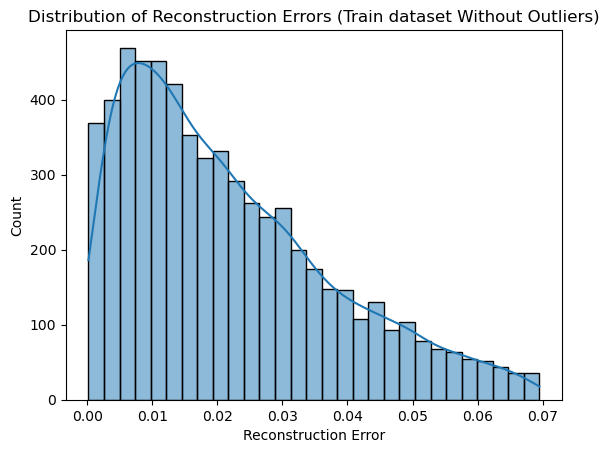

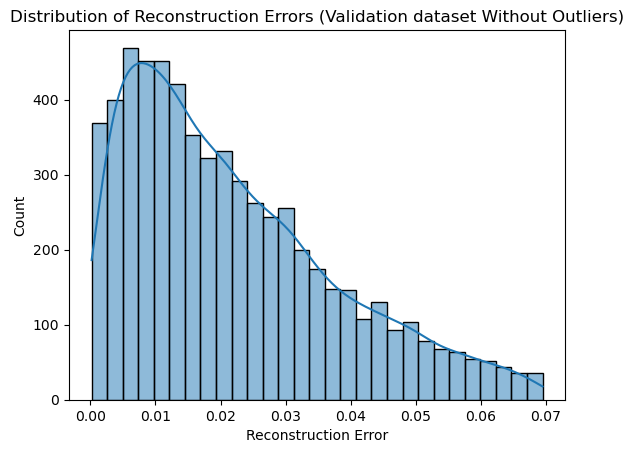

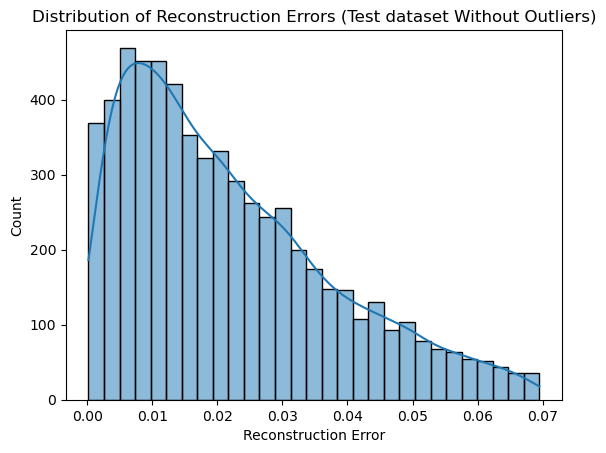

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the datasets
datasets = {'Train': X_train, 'Validation': X_val, 'Test': X_test}

# Plot the reconstruction errors
autoencoder.plot_reconstruction_errors(datasets)


## Lasso regression model from questionnaire items to factors generated with NMF (from Toby)

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]
g:\ABCD\script\trail\trail_tsne_RF\factor analysis\Autoencoder\utils.py:456: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(self.alpha_values)


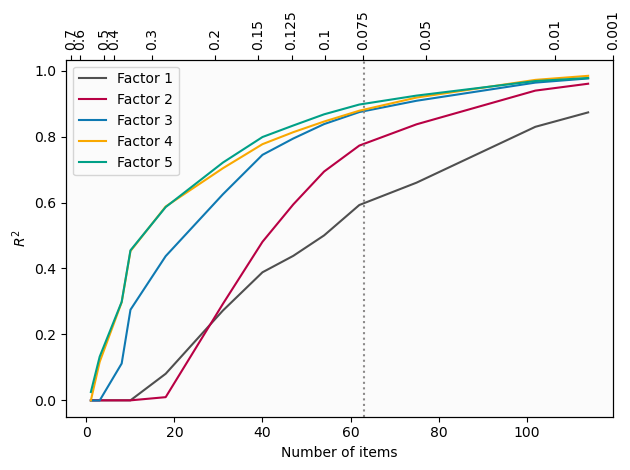

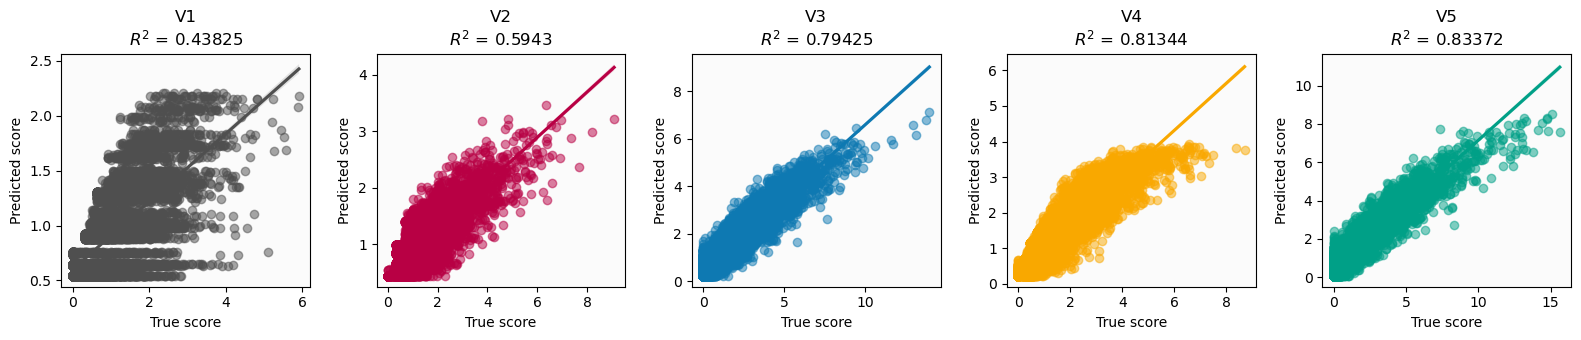

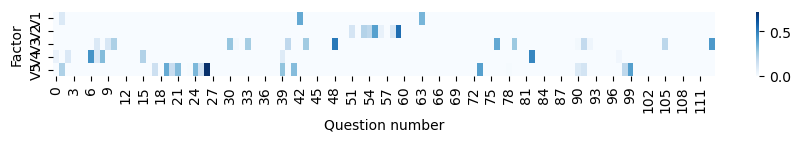

In [4]:
from utils import LassoAnalysis

qns = X
scores = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_W.csv').iloc[:,2:]

# Initialize the LassoAnalysis class
lasso_analysis = LassoAnalysis(qns, scores)

# Perform the analysis
lasso_analysis.perform_analysis()

# Plot R² values
lasso_analysis.plot_r2_values()

# Plot factor predictions
lasso_analysis.plot_factor_predictions(alpha=0.125)

# Plot heatmap of coefficients
lasso_analysis.plot_heatmap(alpha=0.125)

# To be continued: 

## From neuroimaging data to latent factors (to be continued)

In [19]:
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_gp.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv').iloc[:, 1:]
# labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# # only keep the  column.('cbcl_scr_syn_anxdep_t')
# labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
# labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]
data = data.drop(columns=['src_subject_id'])
# reshaped_array = scores.iloc[:,1].to_numpy().reshape(-1, 1)

In [18]:
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_gp.csv")
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

data

,src_subject_id,rsfmri_c_ngd_ad_ngd_ad,rsfmri_c_ngd_ad_ngd_cgc,rsfmri_c_ngd_ad_ngd_ca,rsfmri_c_ngd_ad_ngd_dt,rsfmri_c_ngd_ad_ngd_dla,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_n,rsfmri_c_ngd_ad_ngd_rspltp,rsfmri_c_ngd_ad_ngd_sa,...,rsfmri_c_ngd_vs_ngd_dt,rsfmri_c_ngd_vs_ngd_dla,rsfmri_c_ngd_vs_ngd_fo,rsfmri_c_ngd_vs_ngd_n,rsfmri_c_ngd_vs_ngd_rspltp,rsfmri_c_ngd_vs_ngd_sa,rsfmri_c_ngd_vs_ngd_smh,rsfmri_c_ngd_vs_ngd_smm,rsfmri_c_ngd_vs_ngd_vta,rsfmri_c_ngd_vs_ngd_vs
0,NDAR_INV003RTV85,0.471330,0.256267,-0.076960,-0.116451,0.022202,-0.036302,-0.057183,-0.048132,0.006416,...,-0.088894,0.055355,-0.076806,-0.006004,0.228366,-0.150867,-0.064416,0.098679,-0.155134,0.371960
1,NDAR_INV005V6D2C,0.279435,0.116256,0.063664,-0.024781,-0.000840,-0.023421,-0.016284,0.022696,0.056241,...,-0.136596,0.017415,-0.111623,-0.077958,0.049159,-0.065420,-0.061459,0.075145,-0.071943,0.346746
2,NDAR_INV007W6H7B,0.294463,0.209772,-0.071834,-0.138693,-0.035168,0.044412,-0.041321,-0.185939,0.071985,...,-0.136426,-0.018266,-0.096822,-0.050623,0.002644,-0.017955,-0.060259,0.070566,-0.076156,0.400397
3,NDAR_INV00BD7VDC,0.241918,0.163942,-0.090651,-0.044039,0.012523,-0.022455,-0.005482,-0.124627,0.095889,...,-0.117847,0.007997,-0.117152,-0.028143,0.079898,-0.066724,-0.029856,-0.038823,-0.092095,0.334313
6,NDAR_INV00CY2MDM,0.395300,0.180940,-0.142808,-0.073424,-0.049414,-0.144481,-0.024881,-0.012894,-0.036592,...,-0.202610,0.014283,-0.200163,-0.091514,0.154572,-0.210839,0.033060,0.159728,-0.125210,0.485745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.315367,0.176642,-0.010926,-0.019208,-0.030765,-0.062264,0.021828,-0.043990,0.140031,...,-0.075473,-0.008800,-0.103751,-0.035379,0.183831,-0.019576,-0.045539,-0.012037,-0.054182,0.333367
22120,NDAR_INVZZNX6W2P,0.343187,0.142774,-0.055901,-0.046064,-0.006279,0.013171,0.017289,-0.064605,-0.014693,...,-0.164360,0.059505,-0.157277,-0.037063,0.264306,-0.143545,-0.082002,0.015764,-0.126353,0.484629
22123,NDAR_INVZZPKBDAC,0.404070,0.300714,-0.167735,-0.093816,-0.044867,0.019305,0.049103,-0.157262,0.192685,...,-0.183933,0.022202,-0.130174,-0.066710,0.179635,-0.012360,-0.098269,0.069790,-0.126898,0.462496
22125,NDAR_INVZZZ2ALR6,0.411105,0.209193,-0.041473,-0.063504,-0.102791,-0.046049,-0.009828,-0.162120,0.026045,...,-0.152191,0.022720,-0.132211,-0.046361,0.170122,-0.094498,0.000854,0.030236,-0.153170,0.351791


In [21]:
data

,rsfmri_c_ngd_ad_ngd_ad,rsfmri_c_ngd_ad_ngd_cgc,rsfmri_c_ngd_ad_ngd_ca,rsfmri_c_ngd_ad_ngd_dt,rsfmri_c_ngd_ad_ngd_dla,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_n,rsfmri_c_ngd_ad_ngd_rspltp,rsfmri_c_ngd_ad_ngd_sa,rsfmri_c_ngd_ad_ngd_smh,...,rsfmri_c_ngd_vs_ngd_dt,rsfmri_c_ngd_vs_ngd_dla,rsfmri_c_ngd_vs_ngd_fo,rsfmri_c_ngd_vs_ngd_n,rsfmri_c_ngd_vs_ngd_rspltp,rsfmri_c_ngd_vs_ngd_sa,rsfmri_c_ngd_vs_ngd_smh,rsfmri_c_ngd_vs_ngd_smm,rsfmri_c_ngd_vs_ngd_vta,rsfmri_c_ngd_vs_ngd_vs
0,0.471330,0.256267,-0.076960,-0.116451,0.022202,-0.036302,-0.057183,-0.048132,0.006416,0.199033,...,-0.088894,0.055355,-0.076806,-0.006004,0.228366,-0.150867,-0.064416,0.098679,-0.155134,0.371960
1,0.279435,0.116256,0.063664,-0.024781,-0.000840,-0.023421,-0.016284,0.022696,0.056241,0.110631,...,-0.136596,0.017415,-0.111623,-0.077958,0.049159,-0.065420,-0.061459,0.075145,-0.071943,0.346746
2,0.294463,0.209772,-0.071834,-0.138693,-0.035168,0.044412,-0.041321,-0.185939,0.071985,0.096365,...,-0.136426,-0.018266,-0.096822,-0.050623,0.002644,-0.017955,-0.060259,0.070566,-0.076156,0.400397
3,0.241918,0.163942,-0.090651,-0.044039,0.012523,-0.022455,-0.005482,-0.124627,0.095889,0.151396,...,-0.117847,0.007997,-0.117152,-0.028143,0.079898,-0.066724,-0.029856,-0.038823,-0.092095,0.334313
6,0.395300,0.180940,-0.142808,-0.073424,-0.049414,-0.144481,-0.024881,-0.012894,-0.036592,0.321739,...,-0.202610,0.014283,-0.200163,-0.091514,0.154572,-0.210839,0.033060,0.159728,-0.125210,0.485745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.315367,0.176642,-0.010926,-0.019208,-0.030765,-0.062264,0.021828,-0.043990,0.140031,0.099674,...,-0.075473,-0.008800,-0.103751,-0.035379,0.183831,-0.019576,-0.045539,-0.012037,-0.054182,0.333367
22120,0.343187,0.142774,-0.055901,-0.046064,-0.006279,0.013171,0.017289,-0.064605,-0.014693,0.149963,...,-0.164360,0.059505,-0.157277,-0.037063,0.264306,-0.143545,-0.082002,0.015764,-0.126353,0.484629
22123,0.404070,0.300714,-0.167735,-0.093816,-0.044867,0.019305,0.049103,-0.157262,0.192685,0.052396,...,-0.183933,0.022202,-0.130174,-0.066710,0.179635,-0.012360,-0.098269,0.069790,-0.126898,0.462496
22125,0.411105,0.209193,-0.041473,-0.063504,-0.102791,-0.046049,-0.009828,-0.162120,0.026045,0.078251,...,-0.152191,0.022720,-0.132211,-0.046361,0.170122,-0.094498,0.000854,0.030236,-0.153170,0.351791


In [67]:
#筛选出所有包含_ad_的data
data1 = data.loc[:, data.columns.str.contains('_ad_')]
data1

,rsfmri_c_ngd_ad_ngd_ad,rsfmri_c_ngd_ad_ngd_cgc,rsfmri_c_ngd_ad_ngd_ca,rsfmri_c_ngd_ad_ngd_dt,rsfmri_c_ngd_ad_ngd_dla,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_n,rsfmri_c_ngd_ad_ngd_rspltp,rsfmri_c_ngd_ad_ngd_sa,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,rsfmri_c_ngd_ad_ngd_vta,rsfmri_c_ngd_ad_ngd_vs
0,0.471330,0.256267,-0.076960,-0.116451,0.022202,-0.036302,-0.057183,-0.048132,0.006416,0.199033,0.227614,0.030371,-0.078547
1,0.279435,0.116256,0.063664,-0.024781,-0.000840,-0.023421,-0.016284,0.022696,0.056241,0.110631,0.235843,0.051480,0.005428
2,0.294463,0.209772,-0.071834,-0.138693,-0.035168,0.044412,-0.041321,-0.185939,0.071985,0.096365,0.256924,0.076818,-0.012271
3,0.241918,0.163942,-0.090651,-0.044039,0.012523,-0.022455,-0.005482,-0.124627,0.095889,0.151396,0.163871,0.105660,-0.035867
6,0.395300,0.180940,-0.142808,-0.073424,-0.049414,-0.144481,-0.024881,-0.012894,-0.036592,0.321739,0.464358,0.073140,0.024973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.315367,0.176642,-0.010926,-0.019208,-0.030765,-0.062264,0.021828,-0.043990,0.140031,0.099674,0.158197,0.082964,-0.065184
22120,0.343187,0.142774,-0.055901,-0.046064,-0.006279,0.013171,0.017289,-0.064605,-0.014693,0.149963,0.255056,0.088455,-0.056290
22123,0.404070,0.300714,-0.167735,-0.093816,-0.044867,0.019305,0.049103,-0.157262,0.192685,0.052396,0.351278,0.180253,-0.090375
22125,0.411105,0.209193,-0.041473,-0.063504,-0.102791,-0.046049,-0.009828,-0.162120,0.026045,0.078251,0.213641,0.061433,-0.094612


In [ ]:
latent_factors

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6
0,-0.380717,-0.204297,-0.013780,-0.311701,-0.364552,-0.164136
1,-0.432631,0.261826,0.083665,-0.324311,-0.473164,0.004208
2,0.853693,0.595317,-0.988071,-1.815727,-0.587024,0.319114
3,0.105407,-0.194683,-0.628278,-0.687728,0.149507,0.346314
4,-0.210956,-1.002879,0.549645,-0.019354,0.863258,0.937941
...,...,...,...,...,...,...
10647,-0.570448,-0.760993,0.133852,0.158894,1.856123,-0.389958
10648,-0.604179,0.019773,0.254816,-0.149933,0.329864,0.328062
10649,-0.283147,0.045985,0.073600,-0.484009,-0.345015,-0.140364
10650,-0.520797,0.315002,-0.104838,-0.338477,0.242765,-0.010963


Spearman 相关性: 0.0345 (p=0.00145), MSE: 0.3762


c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21449 (\N{CJK UNIFIED IDEOGRAPH-53C9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anacond

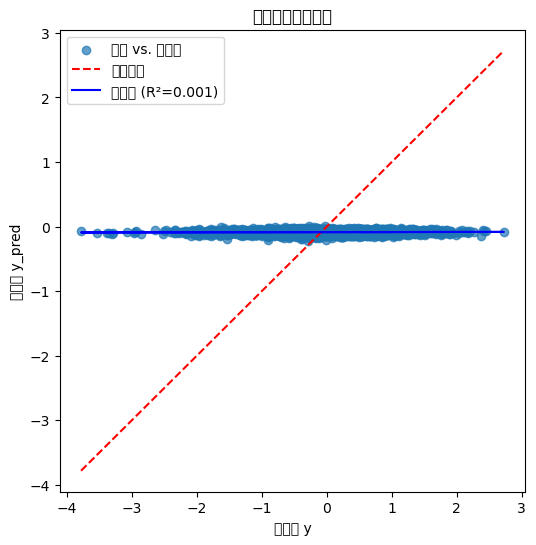

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error


# ========== 2. 交叉验证与预测 ==========
def cross_validate_prediction(X, y, cv_type="loocv", k_folds=10, feature_selection=False):
    if cv_type == "loocv":
        cv = LeaveOneOut()
    elif cv_type == "kfold":
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=9873)
    else:
        raise ValueError("cv_type 必须是 'loocv' 或 'kfold'")

    y_actual, y_pred = [], []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if feature_selection:
            feature_corr = np.array([
                stats.spearmanr(X_train[:, i], y_train)[0] if len(np.unique(X_train[:, i])) > 1 else 0
                for i in range(X_train.shape[1])
            ])
            selected_features = np.where(np.abs(feature_corr) > 0.1)[0]
            if len(selected_features) == 0:
                selected_features = np.arange(X_train.shape[1])
            X_train, X_test = X_train[:, selected_features], X_test[:, selected_features]

        # model = LinearRegression()  # 或 Lasso(alpha=0.01)
        model = Lasso(alpha=0.01)
        model.fit(X_train, y_train)

        y_pred.extend(model.predict(X_test))
        y_actual.extend(y_test)

    return np.array(y_actual), np.array(y_pred)


# ========== 3. 计算评估指标 ==========
def evaluate_performance(y_actual, y_pred):
    spearman_corr, spearman_p = stats.spearmanr(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)

    if np.isnan(spearman_corr):
        spearman_corr, spearman_p = 0, 1

    print(f"Spearman 相关性: {spearman_corr:.4f} (p={spearman_p:.5f}), MSE: {mse:.4f}")


# ========== 4. 画图（预测 vs 真实值） ==========
def plot_results(y_actual, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7, label="预测 vs. 真实值")
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], "r--", label="理想情况")

    model = LinearRegression()
    model.fit(y_actual.reshape(-1, 1), y_pred)
    y_fit = model.predict(y_actual.reshape(-1, 1))
    plt.plot(y_actual, y_fit, "b-", label=f"拟合线 (R²={model.score(y_actual.reshape(-1, 1), y_pred):.3f})")

    plt.xlabel("真实值 y")
    plt.ylabel("预测值 y_pred")
    plt.title("交叉验证预测结果")
    plt.legend()
    plt.show()

# ========== 运行代码 ==========
if __name__ == "__main__":
    # 1. 读取数据
    X = np.array(data1)  # 转换为 numpy 数组，确保索引不影响
    y = latent_factors.iloc[:, 0].values  # 显式转换为 numpy 数组
    # y = factor_scores[:,0]
    # X = data1.loc[:, :].values  # 确保 data1 按列取所有值
    # y = latent_df.iloc[:, 0].reindex(data1.index).values  # 让 y 的索引与 data1 对齐
    scaler = StandardScaler()
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 2. 进行交叉验证（LOOCV 或 KFold），选择是否启用特征选择
    cv_type = "loocv"  # 可改成 "kfold"
    feature_selection = True  # 是否开启特征选择

    y_actual, y_pred = cross_validate_prediction(X_train, y_train, cv_type=cv_type, k_folds=10, feature_selection=feature_selection)

    # 3. 计算 Spearman 相关性 & 误差
    evaluate_performance(y_actual, y_pred)

    # 4. 画图
    plot_results(y_actual, y_pred)


Spearman 相关性: 0.0397 (p=0.00025), MSE: 0.8274


c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21449 (\N{CJK UNIFIED IDEOGRAPH-53C9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anacond

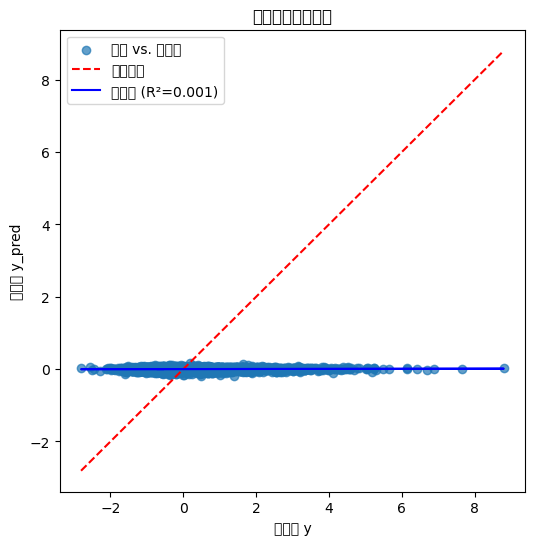

In [106]:
# ========== 运行代码 ==========
if __name__ == "__main__":
    # 1. 读取数据
    X = np.array(data1)  # 转换为 numpy 数组，确保索引不影响
    # y = latent_df.iloc[:, 0].values  # 显式转换为 numpy 数组
    y = factor_scores[:,0]
    # X = data1.loc[:, :].values  # 确保 data1 按列取所有值
    # y = latent_df.iloc[:, 0].reindex(data1.index).values  # 让 y 的索引与 data1 对齐
    scaler = StandardScaler()
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 2. 进行交叉验证（LOOCV 或 KFold），选择是否启用特征选择
    cv_type = "loocv"  # 可改成 "kfold"
    feature_selection = True  # 是否开启特征选择

    y_actual, y_pred = cross_validate_prediction(X_train, y_train, cv_type=cv_type, k_folds=10, feature_selection=feature_selection)

    # 3. 计算 Spearman 相关性 & 误差
    evaluate_performance(y_actual, y_pred)

    # 4. 画图
    plot_results(y_actual, y_pred)


# Getting fmri data

In [ ]:
import cx_Oracle
import os

# 手动指定 Instant Client 目录
os.environ["PATH"] = "C:\\oracle\\instantclient_23_7;" + os.environ["PATH"]

# 测试 cx_Oracle 是否正确加载
print(cx_Oracle.clientversion())


In [ ]:
# 连接数据库
dsn = cx_Oracle.makedsn("mindarvpc.cqahbwk3l1mb.us-east-1.rds.amazonaws.com", 1521, service_name="ORCL")
conn = cx_Oracle.connect(user="k21116947_1236370", password="", dsn=dsn)

cursor = conn.cursor()

# 查询 ENDPOINT 列的前 10 条记录
query = """
SELECT ENDPOINT
FROM S3_LINKS
WHERE ENDPOINT LIKE '%baseline%' AND ENDPOINT LIKE '%rsfMRI%' AND ENDPOINT LIKE '%NDARINV005V6D2C%' AND ENDPOINT LIKE '%MPROC%' AND ENDPOINT LIKE '%release5%'
"""
cursor.execute(query)

s3_samples = [row[0] for row in cursor.fetchall()]

cursor.close()
conn.close()

print("S3_LINKS 表的 ENDPOINT 列数据示例：")
for url in s3_samples:
    print(url)


S3_LINKS 表的 ENDPOINT 列数据示例：
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111847.tgz
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422103917.tgz
s3://NDAR_Central_3/submission_52682/abcd-mproc-release5/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422103917.tgz
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111312.tgz
s3://NDAR_Central_3/submission_52682/abcd-mproc-release5/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111312.tgz
s3://NDAR_Central_4/submission_32739/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111312.tgz
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422104516.tgz
s3://NDAR_Central_3/submission_52682/abcd-mproc-release5/NDARINV005V6D2C_baselineYear1Arm1_ABCD-

## complete pipeline

In [ ]:
dsn = cx_Oracle.makedsn("mindarvpc.cqahbwk3l1mb.us-east-1.rds.amazonaws.com", 1521, service_name="ORCL")
conn = cx_Oracle.connect(user="k21116947_1236370", password="", dsn=dsn)

cursor = conn.cursor()

query = """
SELECT ENDPOINT
FROM S3_LINKS
WHERE ENDPOINT LIKE '%baseline%' AND ENDPOINT LIKE '%rsfMRI%' AND ENDPOINT LIKE '%NDARINV005V6D2C%' AND ENDPOINT LIKE '%MPROC%' 
"""
cursor.execute(query)

s3_samples = [row[0] for row in cursor.fetchall()]

cursor.close()
conn.close()

#for url in s3_samples:
#    print(url)

np.savetxt('output/s3_links.txt', s3_samples, fmt='%s')


!downloadcmd -dp 1236370 -t output/s3_links.txt -d ./